In [1]:
import pandas as pd
import cv2
import albumentations as A
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_csv('./tensorflow-great-barrier-reef/train.csv')
df.head()

video_id  sequence  video_frame  sequence_frame image_id annotations
0         0     40258            0               0      0-0          []
1         0     40258            1               1      0-1          []
2         0     40258            2               2      0-2          []
3         0     40258            3               3      0-3          []
4         0     40258            4               4      0-4          []

In [3]:
df['annotations'] = df['annotations'].apply(eval)

In [4]:
def clean_annotations(annotations):
    new_annotations = []
    for a in annotations:
        x_max = a['x'] + a['width']
        y_max = a['y'] + a['height']
        if x_max > 1280 or y_max > 720:
            print("We found a broken annotation:", a, x_max, y_max)
        else:
            new_annotations.append(a)
    return new_annotations

In [5]:
df['annotations'] = df['annotations'].apply(clean_annotations)

We found a broken annotation: {'x': 890, 'y': 687, 'width': 28, 'height': 34} 918 721
We found a broken annotation: {'x': 894, 'y': 694, 'width': 28, 'height': 33} 922 727
We found a broken annotation: {'x': 286, 'y': 704, 'width': 85, 'height': 35} 371 739
We found a broken annotation: {'x': 932, 'y': 698, 'width': 32, 'height': 36} 964 734
We found a broken annotation: {'x': 1222, 'y': 395, 'width': 70, 'height': 57} 1292 452
We found a broken annotation: {'x': 559, 'y': 686, 'width': 48, 'height': 35} 607 721
We found a broken annotation: {'x': 693, 'y': 638, 'width': 74, 'height': 83} 767 721
We found a broken annotation: {'x': 374, 'y': 671, 'width': 59, 'height': 50} 433 721
We found a broken annotation: {'x': 315, 'y': 670, 'width': 66, 'height': 51} 381 721
We found a broken annotation: {'x': 640, 'y': 674, 'width': 76, 'height': 68} 716 742
We found a broken annotation: {'x': 526, 'y': 659, 'width': 82, 'height': 64} 608 723
We found a broken annotation: {'x': 526, 'y': 675, '

In [6]:
home = os.getcwd()
root = 'tensorflow-great-barrier-reef/train_images/'
df['n_annotations'] = [len(ann) for ann in df['annotations'].values]
df['image_path'] = home + '/' + root + "video_" + df['video_id'].astype(str) + "/" + df['video_frame'].astype(str) + ".jpg"

In [7]:
def get_seq(data, video_id = 0):
    df_v = data.copy()
    df_v = df[df['video_id'] == video_id]
    sequence = pd.unique(df_v['sequence'])
    sec_dict = {}

    for seq in sequence:
        df_s = df_v[df_v['sequence'] == seq]
        df_a = df_s[df_s['n_annotations'] >0]
        df_a.reset_index(drop = True, inplace = True)
        sec_dict[seq] = df_a
        
    return sec_dict, sequence

In [8]:
def systematic_sampling(data, k = 10):
    object = range(data.shape[0])
    s_s = [object[i] for i in range(0, len(object), k)]
    
    return s_s

In [9]:
def sampling (data,video_id, k = 10):
    sub_sampling = {}

    dict, sequence = get_seq(data = data, video_id = video_id)
    for i, id in enumerate(sequence):
        video = dict[id]
        sam = systematic_sampling(data = video, k = k)
        video_sam = video.iloc[sam]
        video_sam.reset_index(drop = True, inplace = True)
        sub_sampling[i] = video_sam
        
    dataframes_join = pd.concat(sub_sampling.values(), axis=0, ignore_index=True)
    return dataframes_join

In [10]:
def resize_image_and_bboxes(image_path, bboxes, target_width=1280, target_height=720):
    
    image = cv2.imread(image_path)
    albumentations_bboxes = [list(bbox.values()) for bbox in bboxes]

    transform = A.Compose([
        A.Resize(target_height, target_width, p=1.0),
    ], bbox_params=A.BboxParams(format='coco', label_fields=['category_id']))

    transformed = transform(image=image, bboxes=albumentations_bboxes, category_id=[1] * len(albumentations_bboxes))

    new_bboxes = []
    for bbox in transformed['bboxes']:
        x_center = (2 * bbox[0] + bbox[2]) / (2 * target_width)
        y_center = (2 * bbox[1] + bbox[3]) / (2 *target_height)
        width = bbox[2] / target_width
        height = bbox[3] / target_height
        new_bboxes.append([x_center, y_center, width, height])

    return transformed['image'], transformed['bboxes'], transformed['category_id'], new_bboxes

In [1]:
def divide_image_and_bboxes(image_path, bboxes):
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    # Calcular dimensiones para dividir la imagen en 4 partes
    width_mid, height_mid = width // 2, height // 2

    # Dividir la imagen en 4 partes
    images = [
        image[:height_mid, :width_mid],  # Arriba izquierda
        image[:height_mid, width_mid:],  # Arriba derecha
        image[height_mid:, :width_mid],  # Abajo izquierda
        image[height_mid:, width_mid:]   # Abajo derecha
    ]

    new_bboxes_all = []

    for img in images:
        img_height, img_width, _ = img.shape
        new_bboxes = []

        for bbox in bboxes:
            x_min, y_min, box_width, box_height = [bbox[k] for k in ['x_min', 'y_min', 'width', 'height']]

            # Verificar si el bbox está dentro de la imagen actual
            if (x_min < img_width and y_min < img_height):
                # Ajustar las coordenadas y dimensiones del bbox
                x_min_adj = max(x_min - img_width * (img is images[1] or img is images[3]), 0)
                y_min_adj = max(y_min - img_height * (img is images[2] or img is images[3]), 0)
                box_width_adj = min(box_width, img_width - x_min_adj)
                box_height_adj = min(box_height, img_height - y_min_adj)

                new_bboxes.append([x_min_adj, y_min_adj, box_width_adj, box_height_adj])

        new_bboxes_all.append(new_bboxes)

    return images, new_bboxes_all

In [11]:
BOX_COLOR = (0, 0, 255) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img[:,:,::-1])

In [12]:
category_id_to_name = {1: 'Starfish'}

In [13]:
new_df0 = sampling(df, 0, 3)
new_df1 = sampling(df, 1, 5)
new_df2 = sampling(df, 2, 5)

In [14]:
new_df0

video_id  sequence  video_frame  sequence_frame image_id  \
0           0     40258           16              16     0-16   
1           0     40258           19              19     0-19   
2           0     40258           22              22     0-22   
3           0     40258           25              25     0-25   
4           0     40258           28              28     0-28   
..        ...       ...          ...             ...      ...   
711         0       996        12305             880  0-12305   
712         0       996        12308             883  0-12308   
713         0       996        12311             886  0-12311   
714         0       996        12314             889  0-12314   
715         0       996        12317             892  0-12317   

                                           annotations  n_annotations  \
0    [{'x': 559, 'y': 213, 'width': 50, 'height': 32}]              1   
1    [{'x': 556, 'y': 214, 'width': 50, 'height': 32}]              1   
2    [{'x': 538, 'y': 209, 'width': 56, 'height': 47}]              1   
3    [{'x': 529, 'y': 200, 'width': 61, 'height': 50}]              1   
4    [{'x': 519, 'y': 187, 'width': 66, 'height': 52}]              1   
..                                                 ...            ...   
711  [{'x': 997, 'y': 545, 'width': 36, 'height': 29}]              1   
712  [{'x': 1007, 'y': 573, 'width': 39, 'height': ...              1   
713  [{'x': 1017, 'y': 601, 'width': 41, 'height': ...              1   
714  [{'x': 1028, 'y': 637, 'width': 42, 'height': ...              1   
715  [{'x': 1040, 'y': 678, 'width': 42, 'height': ...              1   

                                            image_path  
0    /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
1    /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
2    /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
3    /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
4    /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
..                                                 ...  
711  /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
712  /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
713  /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
714  /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
715  /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  

[716 rows x 8 columns]

In [15]:
obj = new_df0.iloc[155].to_dict()

image_path = obj['image_path']
bboxes_coco = obj['annotations']
img, bboxes, category, yolo_b = resize_image_and_bboxes(image_path, bboxes_coco)


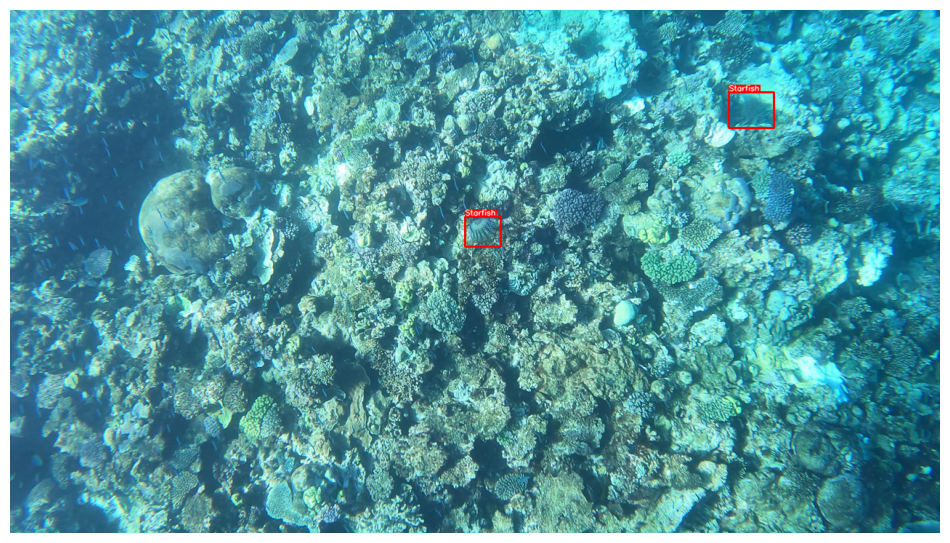

In [16]:
visualize(
    img,
    bboxes,
    category,
    category_id_to_name,
)

In [17]:
def crear_y_mover_carpeta():
    carpeta = 'starfish'
    if not os.path.exists(carpeta):
        os.makedirs(carpeta)
        print(f'Se creó la carpeta {carpeta}')
        
    os.chdir(carpeta)
    print(f'Ahora te encuentras en la carpeta {carpeta}')

crear_y_mover_carpeta()

Ahora te encuentras en la carpeta starfish


In [18]:
os.getcwd()

'/home/el_rancio_dave/Documents/IA/YOLO/starfish'

In [19]:
def preprocessing(partition, data):
    os.makedirs(f'{partition}/images', exist_ok = True)
    os.makedirs(f'{partition}/labels', exist_ok = True)
    
    for img_id in tqdm(range(data.shape[0])):
        obj = data.iloc[img_id].to_dict()
        image_path = obj['image_path']
        bboxes_coco = obj['annotations']
        img, _, _, yolo_b = resize_image_and_bboxes(image_path, bboxes_coco)
        
        new_image_path = f'./{partition}/images/{img_id}.jpg'  
        cv2.imwrite(new_image_path, img)
        
        items = []
        for lis_b in yolo_b:
            xc, yc, w, h = lis_b
            items.append(f'0 {xc} {yc} {w} {h}')
            
        with open (f'{partition}/labels/{img_id}.txt', 'w') as f:
            for item in items:
                f.write(f'{item}\n')

In [20]:
preprocessing('train', new_df0)

100%|██████████| 716/716 [00:22<00:00, 31.35it/s]


In [21]:
preprocessing('valid', new_df1)
preprocessing('test', new_df2)

100%|██████████| 137/137 [00:04<00:00, 30.06it/s]


In [22]:
os.getcwd()

'/home/el_rancio_dave/Documents/IA/YOLO/starfish'

In [23]:
!touch data.yaml

In [24]:
df.query('n_annotations >4')

video_id  sequence  video_frame  sequence_frame image_id  \
5474          0     53708         9651             766   0-9651   
5475          0     53708         9652             767   0-9652   
5476          0     53708         9653             768   0-9653   
5477          0     53708         9654             769   0-9654   
5478          0     53708         9655             770   0-9655   
...         ...       ...          ...             ...      ...   
19821         2     22643         5919             556   2-5919   
19822         2     22643         5920             557   2-5920   
19823         2     22643         5921             558   2-5921   
19824         2     22643         5922             559   2-5922   
19825         2     22643         5923             560   2-5923   

                                             annotations  n_annotations  \
5474   [{'x': 307, 'y': 570, 'width': 26, 'height': 2...              5   
5475   [{'x': 307, 'y': 575, 'width': 27, 'height': 2...              5   
5476   [{'x': 307, 'y': 581, 'width': 27, 'height': 3...              5   
5477   [{'x': 307, 'y': 586, 'width': 28, 'height': 3...              5   
5478   [{'x': 307, 'y': 590, 'width': 28, 'height': 3...              5   
...                                                  ...            ...   
19821  [{'x': 536, 'y': 600, 'width': 48, 'height': 5...              5   
19822  [{'x': 532, 'y': 608, 'width': 49, 'height': 5...              5   
19823  [{'x': 529, 'y': 615, 'width': 50, 'height': 5...              5   
19824  [{'x': 526, 'y': 622, 'width': 51, 'height': 5...              5   
19825  [{'x': 526, 'y': 632, 'width': 51, 'height': 5...              5   

                                              image_path  
5474   /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
5475   /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
5476   /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
5477   /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
5478   /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
...                                                  ...  
19821  /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
19822  /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
19823  /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
19824  /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  
19825  /home/el_rancio_dave/Documents/IA/YOLO/tensorf...  

[561 rows x 8 columns]

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [43]:
os.chdir('/home/el_rancio_dave/Documents/IA/YOLO')

In [45]:
#url = './starfish/test/images/20.jpg'
url = './tensorflow-great-barrier-reef/train_images/video_2/6348.jpg'

In [46]:
imagen = cv2.imread(url, cv2.IMREAD_COLOR)

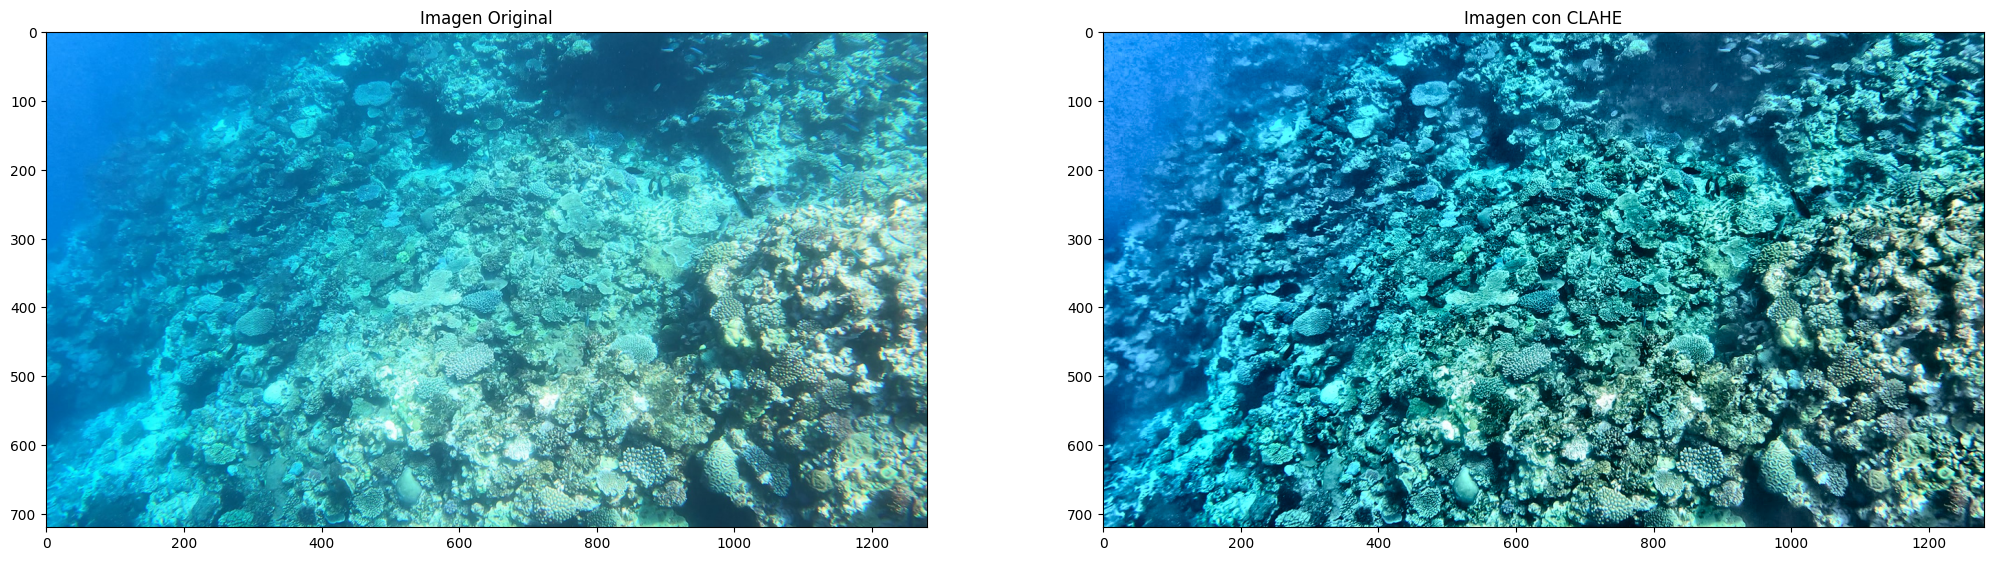

In [52]:
imagen = cv2.imread(url, cv2.IMREAD_COLOR)

# Convertir la imagen a espacio de color LAB
lab = cv2.cvtColor(imagen, cv2.COLOR_BGR2LAB)

# Separar los canales
l, a, b = cv2.split(lab)

# Aplicar CLAHE al canal L (luminosidad)
# clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(20,20))
l_clahe = clahe.apply(l)

# Combinar los canales de nuevo
lab_clahe = cv2.merge((l_clahe, a, b))

# Convertir de vuelta a espacio de color BGR
imagen_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

plt.figure(figsize=(25, 20))
plt.subplot(121), plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)), plt.title('Imagen Original')
plt.subplot(122), plt.imshow(cv2.cvtColor(imagen_clahe, cv2.COLOR_BGR2RGB)), plt.title('Imagen con CLAHE')
plt.show()

In [51]:
cv2.imwrite('imagen1.jpg', imagen)
cv2.imwrite('imagen2.jpg', imagen_clahe)

True

In [54]:
def dividir_imagen(imagen, filas=2, columnas=2):
    """
    Divide una imagen en un número especificado de filas y columnas.

    :param imagen: Imagen a dividir.
    :param filas: Número de filas.
    :param columnas: Número de columnas.
    :return: Lista de imágenes divididas.
    """
    altura, anchura = imagen.shape[:2]

    altura_segmento = altura // filas
    anchura_segmento = anchura // columnas

    imagenes_divididas = []

    for i in range(filas):
        for j in range(columnas):
            segmento = imagen[i * altura_segmento: (i + 1) * altura_segmento, 
                             j * anchura_segmento: (j + 1) * anchura_segmento]
            imagenes_divididas.append(segmento)

    return imagenes_divididas

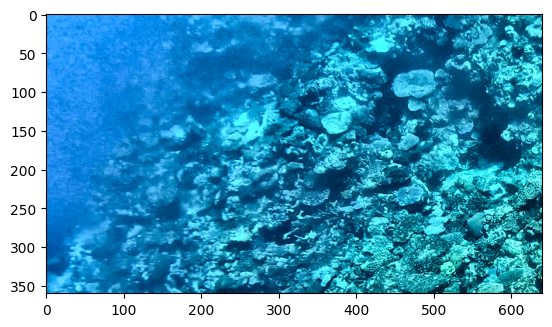

In [59]:
imagenes_divididas = dividir_imagen(imagen_clahe)
plt.imshow(imagenes_divididas[0][:, :, ::-1])

In [60]:
for i, img in enumerate(imagenes_divididas):
    cv2.imwrite(f'imagen_dividida_{i}.jpg', img)